In [1]:
!pip install matplotlib==3.5 captum torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.12.2 requires matplotlib>=3.6.0, but you have matplotlib 3.5.0 which is incompatible.


In [1]:
import os, sys, itertools, glob, torch, torchvision, cv2, natsort
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from numpy import asarray
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset, TensorDataset, SubsetRandomSampler, ConcatDataset
import torch.optim as optim
import torchvision.transforms as transforms
torch.manual_seed(46)
from torch import nn
import torchinfo
import torch.nn.functional as F
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerGradCam, LayerAttribution, NoiseTunnel, GuidedGradCam

In [3]:
!unzip /content/gaf_imgs.zip -d /content/gaf_imgs

Archive:  /content/gaf_imgs.zip
   creating: /content/gaf_imgs/gaf_imgs/label_0/
  inflating: /content/gaf_imgs/gaf_imgs/label_0/img_0.jpg  
  inflating: /content/gaf_imgs/gaf_imgs/label_0/img_1.jpg  
  inflating: /content/gaf_imgs/gaf_imgs/label_0/img_10.jpg  
  inflating: /content/gaf_imgs/gaf_imgs/label_0/img_11.jpg  
  inflating: /content/gaf_imgs/gaf_imgs/label_0/img_12.jpg  
  inflating: /content/gaf_imgs/gaf_imgs/label_0/img_13.jpg  
  inflating: /content/gaf_imgs/gaf_imgs/label_0/img_14.jpg  
  inflating: /content/gaf_imgs/gaf_imgs/label_0/img_2.jpg  
  inflating: /content/gaf_imgs/gaf_imgs/label_0/img_3.jpg  
  inflating: /content/gaf_imgs/gaf_imgs/label_0/img_4.jpg  
  inflating: /content/gaf_imgs/gaf_imgs/label_0/img_5.jpg  
  inflating: /content/gaf_imgs/gaf_imgs/label_0/img_6.jpg  
  inflating: /content/gaf_imgs/gaf_imgs/label_0/img_7.jpg  
  inflating: /content/gaf_imgs/gaf_imgs/label_0/img_8.jpg  
  inflating: /content/gaf_imgs/gaf_imgs/label_0/img_9.jpg  
   creating: /

## EDA

In [4]:
print('Folders inside the main directory: ', os.listdir("/content/gaf_imgs/gaf_imgs"))

Folders inside the main directory:  ['Stress', 'Baseline']


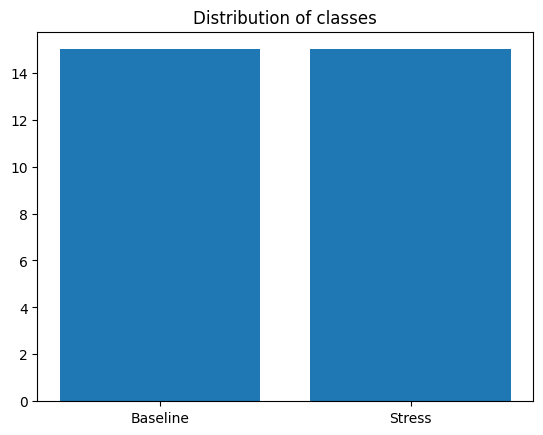

In [5]:
classes = ['Baseline', 'Stress']
sum_images = []
for i in classes:
    img_base_path = "/content/gaf_imgs/gaf_imgs/" + str(i)
    images = os.listdir(img_base_path)
    sum_images.append(len(images))
plt.bar(classes, sum_images)
plt.title('Distribution of classes')
plt.show()

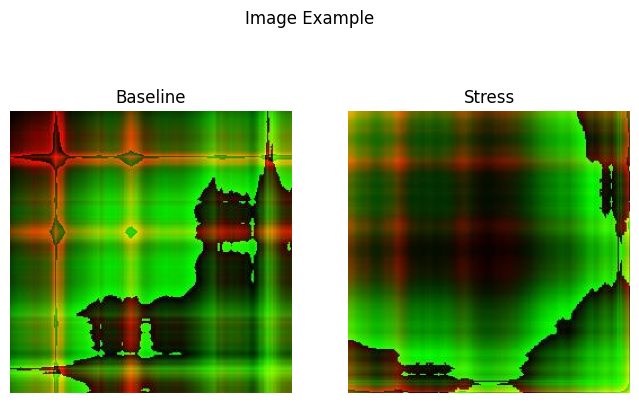

In [6]:
images = []
paths = []

fig,ax = plt.subplots(1,2,figsize = (8,5))
ax = ax.ravel()

for idx, i in enumerate(classes):
    img_base_path = "/content/gaf_imgs/gaf_imgs/" + str(i) #link of the subfolders
    timages = os.listdir(img_base_path) #list of images inside each subfolders
    images_path_to_display = os.path.join(img_base_path, str(timages[0]))
    paths.append(images_path_to_display)
    img = Image.open(images_path_to_display)
    images.append(img)
    image = images[idx]
    ax[idx].axis('off')
    ax[idx].imshow(image,cmap = 'gray')
    ax[idx].set_title(str(i))

plt.suptitle('Image Example')
plt.show()

In [7]:
data = datasets.ImageFolder('/content/gaf_imgs/gaf_imgs')
transform = transforms.Compose([transforms.RandomHorizontalFlip(1),
                                transforms.RandomVerticalFlip(1),
                                transforms.RandomRotation(30),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5227, 0.4927, 0.4786], std=[0.3068, 0.3044, 0.3066])])
class loadData(Dataset):
    def __init__(self, dataset, transform = None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])

        y = self.dataset[index][1]
        return x, y

    def __len__(self):
        return len(self.dataset)
dataset = loadData(data, transform)
print(dataset[0][0].shape)

torch.Size([3, 250, 250])


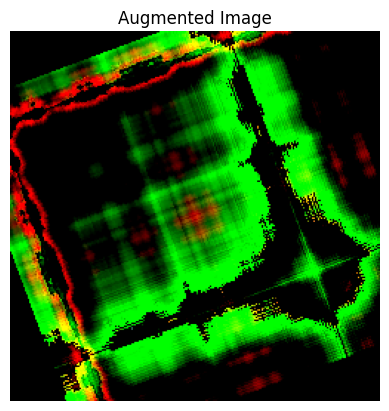

In [8]:
plt.imshow(dataset[3][0].permute(1, 2, 0))
plt.axis('off')
plt.title('Augmented Image')
plt.show()

## Model Architecture

In [9]:
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(1280, 2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
torchinfo.summary(model, (3, 250, 250), batch_dim = 0, col_names = ('input_size', 'output_size', 'num_params'), verbose = 0)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 60.3MB/s]


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #
MobileNetV2                                        [1, 3, 250, 250]          [1, 2]                    --
├─Sequential: 1-1                                  [1, 3, 250, 250]          [1, 1280, 8, 8]           --
│    └─Conv2dNormActivation: 2-1                   [1, 3, 250, 250]          [1, 32, 125, 125]         --
│    │    └─Conv2d: 3-1                            [1, 3, 250, 250]          [1, 32, 125, 125]         864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 125, 125]         [1, 32, 125, 125]         64
│    │    └─ReLU6: 3-3                             [1, 32, 125, 125]         [1, 32, 125, 125]         --
│    └─InvertedResidual: 2-2                       [1, 32, 125, 125]         [1, 16, 125, 125]         --
│    │    └─Sequential: 3-4                        [1, 32, 125, 125]         [1, 16, 125, 125]         896
│    └─InvertedResidual: 2-3           

In [10]:
optimizer = optim.SGD(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

## Training

In [11]:
num_epochs = 10
batch_size = 1
k = 3
splits = KFold(n_splits=k, shuffle=True, random_state=42)
foldperf={}

In [12]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct

def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    with torch.no_grad():
      for images, labels in dataloader:

          images,labels = images.to(device),labels.to(device)
          output = model(images)
          loss=loss_fn(output,labels)
          valid_loss+=loss.item()*images.size(0)
          scores, predictions = torch.max(output.data,1)
          val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct

In [13]:
history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    model.to(device)

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
        test_loss, test_correct=valid_epoch(model,device,test_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

Fold 1
Epoch:1/10 AVG Training Loss:0.751 AVG Test Loss:0.691 AVG Training Acc 45.00 % AVG Test Acc 70.00 %
Epoch:2/10 AVG Training Loss:0.740 AVG Test Loss:0.706 AVG Training Acc 50.00 % AVG Test Acc 50.00 %
Epoch:3/10 AVG Training Loss:0.739 AVG Test Loss:0.675 AVG Training Acc 25.00 % AVG Test Acc 60.00 %
Epoch:4/10 AVG Training Loss:0.701 AVG Test Loss:0.721 AVG Training Acc 50.00 % AVG Test Acc 70.00 %
Epoch:5/10 AVG Training Loss:0.728 AVG Test Loss:0.738 AVG Training Acc 55.00 % AVG Test Acc 40.00 %
Epoch:6/10 AVG Training Loss:0.702 AVG Test Loss:0.777 AVG Training Acc 45.00 % AVG Test Acc 40.00 %
Epoch:7/10 AVG Training Loss:0.730 AVG Test Loss:0.739 AVG Training Acc 35.00 % AVG Test Acc 50.00 %
Epoch:8/10 AVG Training Loss:0.679 AVG Test Loss:0.790 AVG Training Acc 55.00 % AVG Test Acc 40.00 %
Epoch:9/10 AVG Training Loss:0.718 AVG Test Loss:0.630 AVG Training Acc 65.00 % AVG Test Acc 70.00 %
Epoch:10/10 AVG Training Loss:0.666 AVG Test Loss:0.712 AVG Training Acc 65.00 % AVG

In [14]:
avg_train_loss = np.mean(history['train_loss'])
avg_test_loss = np.mean(history['test_loss'])
avg_train_acc = np.mean(history['train_acc'])
avg_test_acc = np.mean(history['test_acc'])

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.4f} \t Average Test Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Test Acc: {:.3f}".format(avg_train_loss,avg_test_loss,avg_train_acc,avg_test_acc))

Performance of 3 fold cross validation
Average Training Loss: 0.7006 	 Average Test Loss: 0.6896 	 Average Training Acc: 52.167 	 Average Test Acc: 56.333


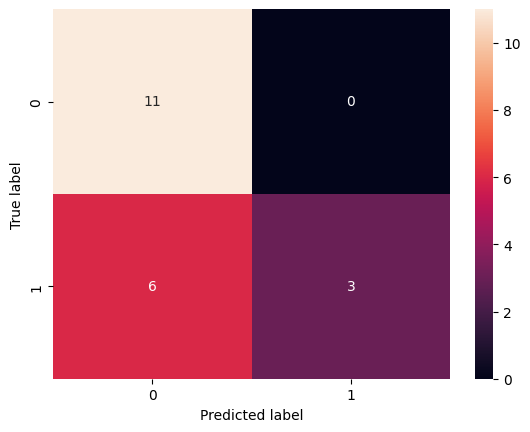

In [16]:
import seaborn as sns
confusion_matrix = np.zeros((2, 2))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(train_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure()
df_cm = pd.DataFrame(confusion_matrix).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## XAI

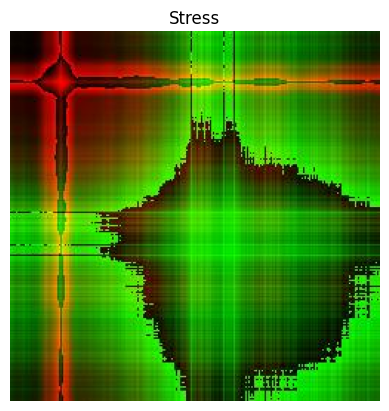

In [22]:
test_img = Image.open('/content/gaf_imgs/gaf_imgs/Stress/img_2.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.title('Stress')
plt.axis('off')
plt.show()

In [23]:
test_transform = transforms.Compose([
 transforms.ToTensor()])

transform_normalize = transforms.Normalize(
     mean=[0.5227, 0.4927, 0.4786], std=[0.3068, 0.3044, 0.3066])

transformed_img = test_transform(test_img)
norm_img = transform_normalize(transformed_img)
input_img = norm_img.unsqueeze(0)
input_img = input_img.to(device)
output = model(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()

tensor(1, device='cuda:0')

### Integrated Gradient

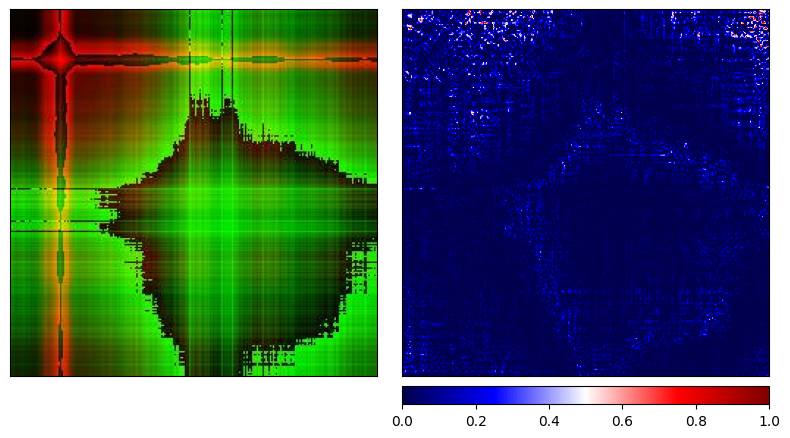

In [28]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

# Ask the algorithm to attribute our output target to
attributions_ig = integrated_gradients.attribute(input_img, target=pred_label_idx, n_steps=200, internal_batch_size=1)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)), #attribution to be visualized
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)), #original_image
                                      ["original_image", "heat_map"], #list of image visualizations
                                      ["all", "positive"],
                                      cmap=cm.seismic,
                                      show_colorbar=True)

### Integrated Gradient + Noise Tunnel

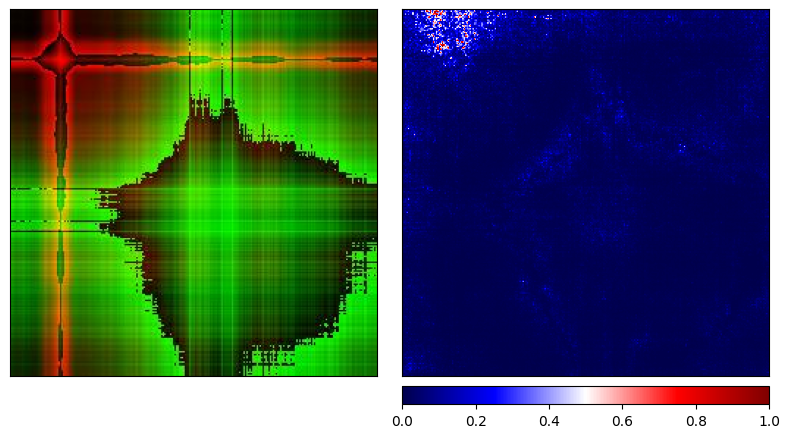

In [32]:
noise_tunnel = NoiseTunnel(integrated_gradients)
#changing noise stdev
attributions_ig_nt = noise_tunnel.attribute(input_img, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx, internal_batch_size=1, stdevs=0.3)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=cm.seismic,
                                      show_colorbar=True)

### Guided GradCam

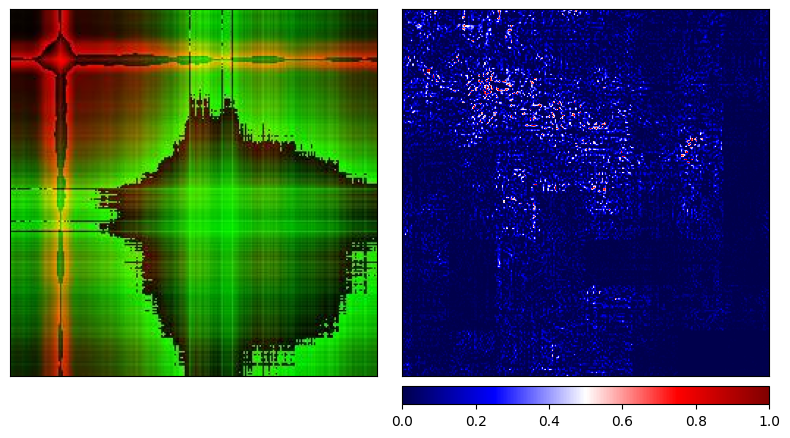

In [34]:
gg = GuidedGradCam(model, model.features[18])
gg_attr = gg.attribute(input_img, pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(gg_attr.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=cm.seismic,
                                      show_colorbar=True)

### Guided GradCam + Noise Tunnel

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


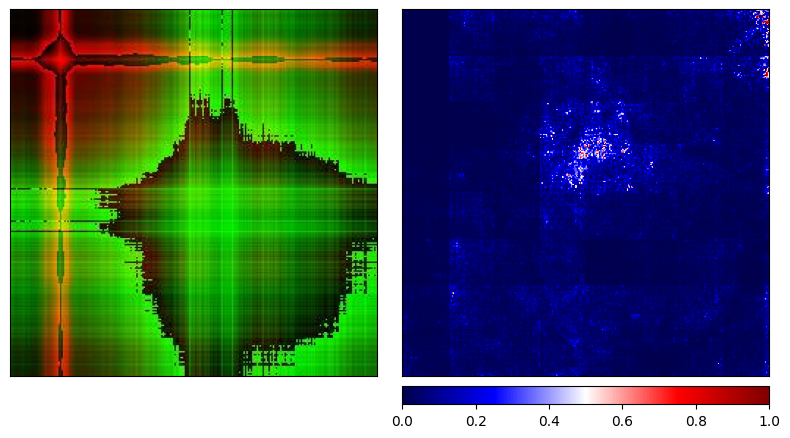

In [37]:
noise_tunnel = NoiseTunnel(gg) #noise tunnel on Guided GradCam
attributions_ig_nt = noise_tunnel.attribute(input_img, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx, stdevs = 0.3)
#visualize
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)), #noise tunneled Guided GradCam
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)), #unormalized img
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=cm.seismic,
                                      show_colorbar=True)

### Layer GradCam

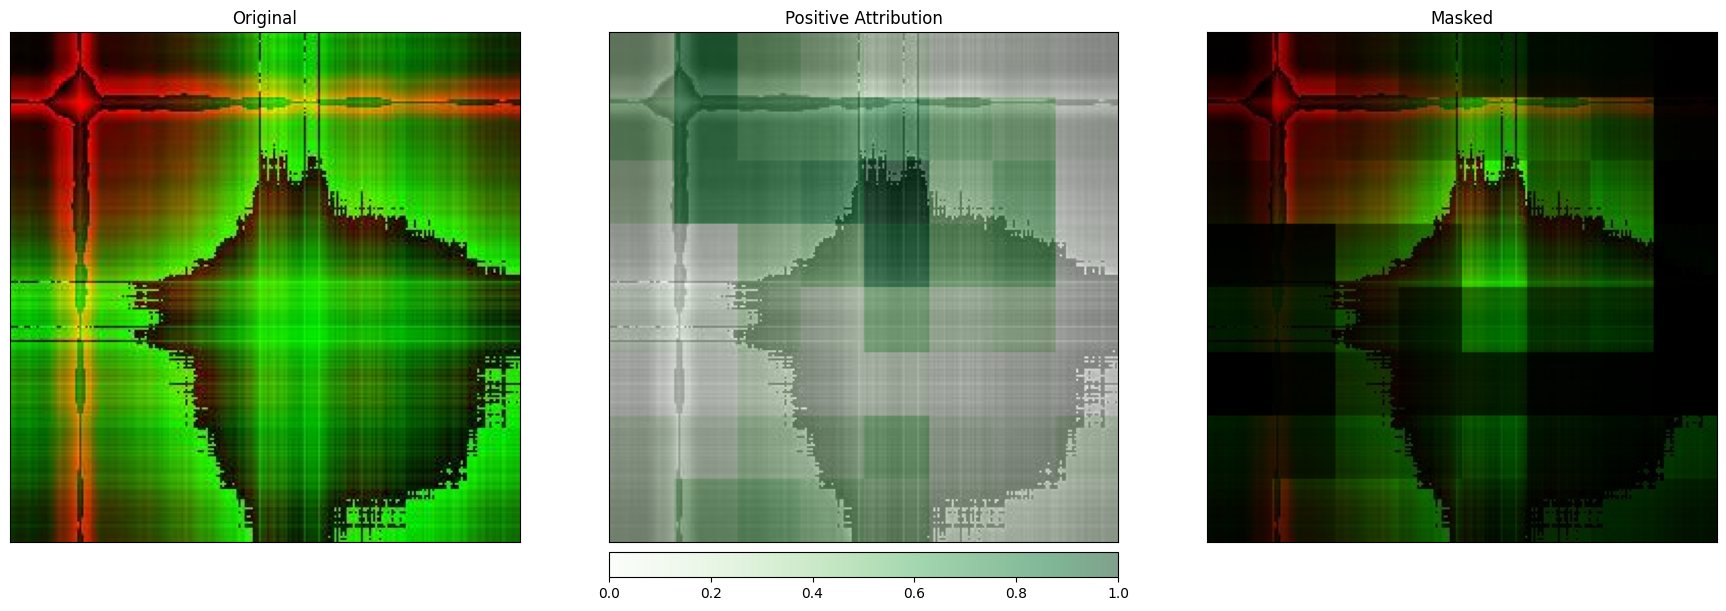

In [38]:
layer_gradcam = LayerGradCam(model, model.features[18][0])
attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)

upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])

_ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      transformed_img.permute(1,2,0).numpy(),
                                      ["original_image","blended_heat_map","masked_image"],
                                      ["all","positive","positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Masked"],
                                      fig_size=(18, 6))

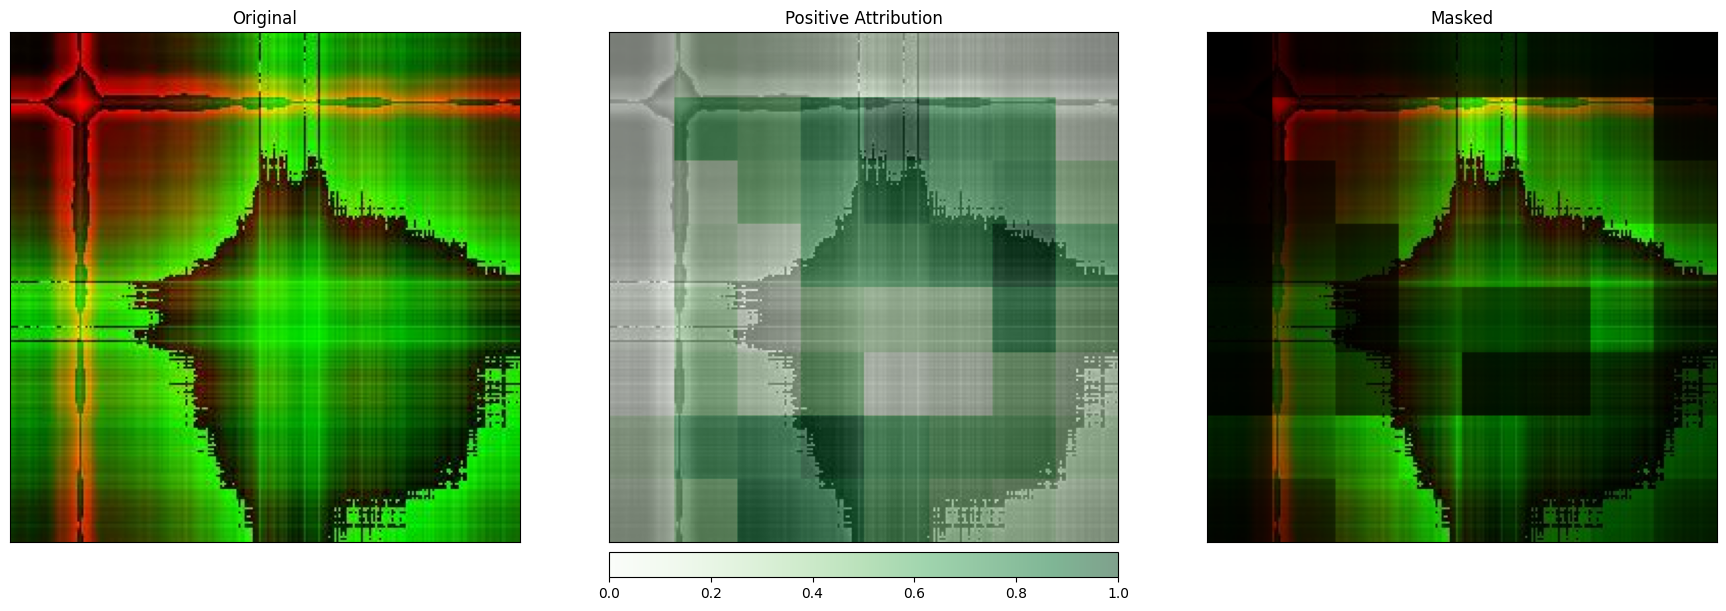

In [40]:
noise_tunnel = NoiseTunnel(layer_gradcam)

attributions_ig_nt = noise_tunnel.attribute(input_img, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx, stdevs=0.3)
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_ig_nt, input_img.shape[2:])
_ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      transformed_img.permute(1,2,0).numpy(),
                                      ["original_image","blended_heat_map","masked_image"],
                                      ["all","positive","positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Masked"],
                                      fig_size=(18, 6))